## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
# !wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randrange

TDC_unit = 25/30 #ns
BX_unit = 25 #ns

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

In [32]:
N  = randrange(10000, len(pd.read_csv('data_000637.txt')))
data = pd.read_csv('data_000637.txt',nrows=N)
print(len(pd.read_csv('data_000637.txt')))
print(len(data))

1310720
749788


2\. Find out the number of BX in a ORBIT (the value 'x').

In [33]:
x=data["BX_COUNTER"].max()+1
print("The max count of BX_COUNTER [#] : ",x,"#"'\n')
orbit = x*BX_unit

The max count of BX_COUNTER [#] :  3564 #



3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

In [34]:
time_lasted = (data["ORBIT_CNT"].max()-data["ORBIT_CNT"].min())*orbit
print("time lasted: ",time_lasted*10**-9, "s")

time lasted:  0.6399162 s


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

In [35]:
data["ABS_NS"] = data["ORBIT_CNT"]*orbit + data["BX_COUNTER"]*BX_unit + data["TDC_MEAS"]*TDC_unit

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

In [36]:
data_r = data.copy()
data_r["HEAD"] = np.random.randint(2, size=len(data))
data_r

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_NS
0,1,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,0,0,64,3869200167,2558,19,3.447457e+14
4,0,0,64,3869200167,2760,25,3.447457e+14
...,...,...,...,...,...,...,...
749783,1,0,63,3869207349,1534,1,3.447464e+14
749784,1,0,60,3869207349,1541,12,3.447464e+14
749785,0,0,61,3869207349,1539,13,3.447464e+14
749786,1,0,62,3869207349,1540,20,3.447464e+14


6\. Create a new DataFrame that contains only the rows with HEAD=1.

In [37]:
data_1=data[data["HEAD"]==1]
data_1

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_NS
0,1,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
...,...,...,...,...,...,...,...
749783,1,0,63,3869207349,1534,1,3.447464e+14
749784,1,0,60,3869207349,1541,12,3.447464e+14
749785,1,0,61,3869207349,1539,13,3.447464e+14
749786,1,0,62,3869207349,1540,20,3.447464e+14


7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

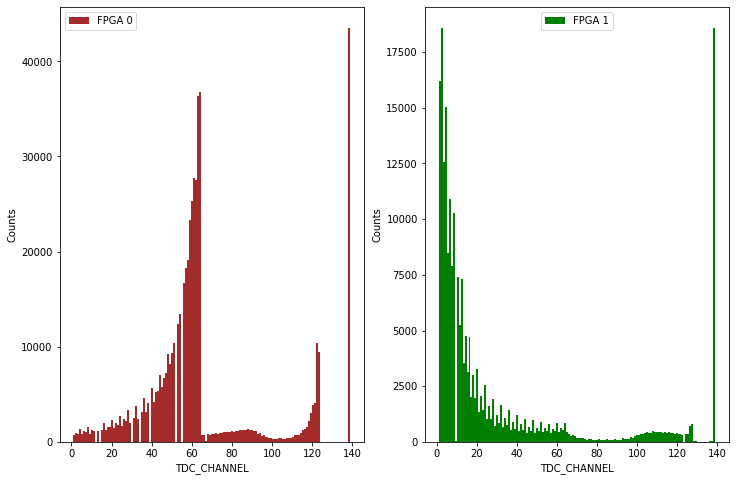

In [38]:
set0 = data[data['FPGA'] == 0]['TDC_CHANNEL']
set1 = data[data['FPGA'] == 1]['TDC_CHANNEL']
fig, (ax1, ax2) = plt.subplots(1,2,sharex=True, figsize=(12,8))
ax1.hist(set0, color='brown', bins=set0.max(), label="FPGA 0")
ax1.legend()
ax1.set_xlabel("TDC_CHANNEL")
ax1.set_ylabel("Counts")
ax2.hist(set1, color='green', bins=set1.max(), label="FPGA 1")
ax2.legend()
ax2.set_xlabel("TDC_CHANNEL")
ax2.set_ylabel("Counts")
plt.show()

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [39]:
print("FPGA = 0 : \n ", data[data['FPGA'] == 0].groupby(['TDC_CHANNEL']).FPGA.count().nlargest(3))
print("FPGA = 1 : \n ",data[data['FPGA'] == 1].groupby(['TDC_CHANNEL']).FPGA.count().nlargest(3))

noisy = data.groupby(["FPGA","TDC_CHANNEL"]).sum()

noisy = [pd.DataFrame([noisy['HEAD'].nlargest(3).index]).T.unstack().iloc[i] for i in range(3)]

print("Noisy Channels (FPGA, TDC_CHANNEL):", noisy)


FPGA = 0 : 
  TDC_CHANNEL
139    43532
64     36740
63     36380
Name: FPGA, dtype: int64
FPGA = 1 : 
  TDC_CHANNEL
2      18595
139    18591
1      16190
Name: FPGA, dtype: int64
Noisy Channels (FPGA, TDC_CHANNEL): [(0, 139), (0, 64), (0, 63)]


9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [40]:
print("Numbers of unique orbits : " , len(data.ORBIT_CNT.unique()))
print("Number of unique orbits with at least one measurement from TDC_CHANNEL=139 : ", len(data[data['TDC_CHANNEL']==139].ORBIT_CNT.unique()))

Numbers of unique orbits :  7179
Number of unique orbits with at least one measurement from TDC_CHANNEL=139 :  7154
